In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
import math
import pandas as pd
import xgboost
import lightgbm
import catboost

from matplotlib.colors import ListedColormap
from scipy.stats import pearsonr
from itertools import combinations
from sklearn.base import BaseEstimator
from sklearn import datasets
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import (RandomForestClassifier,
                              ExtraTreesClassifier,
                              VotingClassifier)
from sklearn.preprocessing import (StandardScaler, LabelEncoder, OneHotEncoder)
from sklearn.tree import (DecisionTreeRegressor,
                          DecisionTreeClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

In [18]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

### Задание 1. Bias-variance trade-off

**2 балла**

Продемонстрируйте bias-variance trade-off для `DecisionTreeRegressor` при изменении глубины дерева. Постройте регрессионную модель функции от одной независимой переменной, представленной в ячейке ниже, используя функцию `plot_regression_predictions` (можете ее как-то поменять, если захочется). Попробуйте разные значения глубины деревьев, при каком значении, на ваш взгляд, модель оптимальна, при каком variance становится слишком большим?

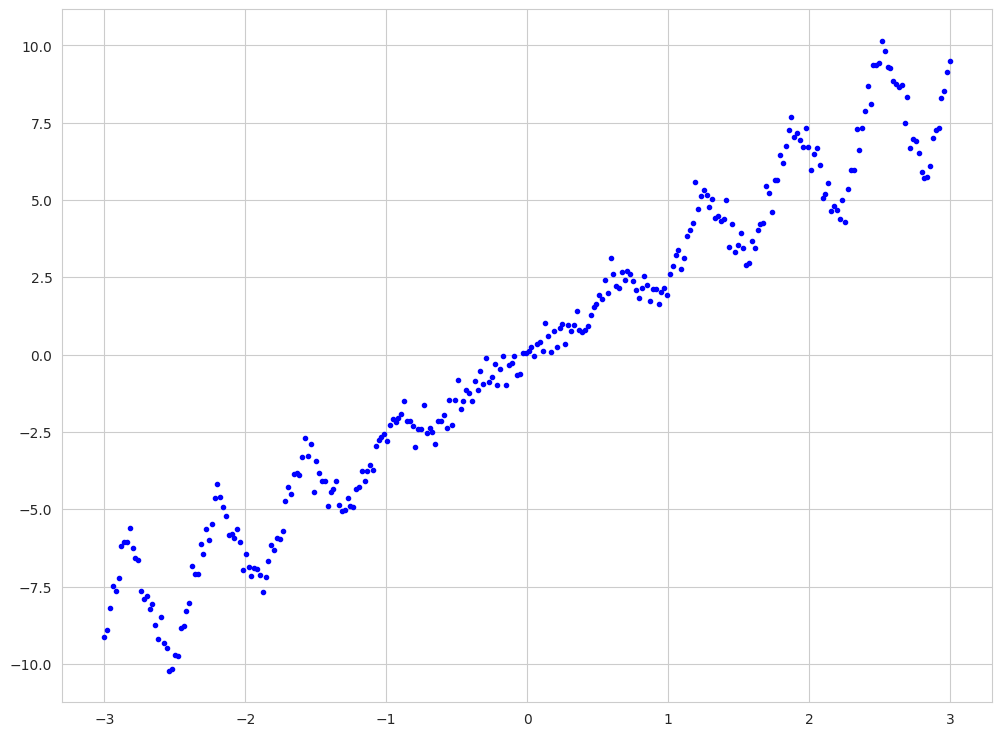

In [7]:
# Сгенерируем какую-нибудь необычную зависимость и научимся ее предсказывать
np.random.seed(42)
m = 300
X = np.linspace(-3, 3, m).reshape(-1, 1)
y = (3 + 2/np.pi * np.arcsin(np.cos(10 * X))) * X
y = y + np.random.randn(m, 1) / 3
plt.plot(X.reshape(-1), y.reshape(-1), "b.");

In [8]:
# Функция для отрисовки предсказаний деревьев решений в случае регрессии
def plot_regression_predictions(tree_reg, X, y, axes=[-3, 3, -10, 10], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x_1$", fontsize=18)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)

    plt.plot(x1, y_pred, linewidth=2, label=r"$\hat{y}$")
    plt.legend()

Изобразите, как меняются предсказания дерева при увеличении максимальной глубины (можно взять что-то в диапазоне от 1 до 15):

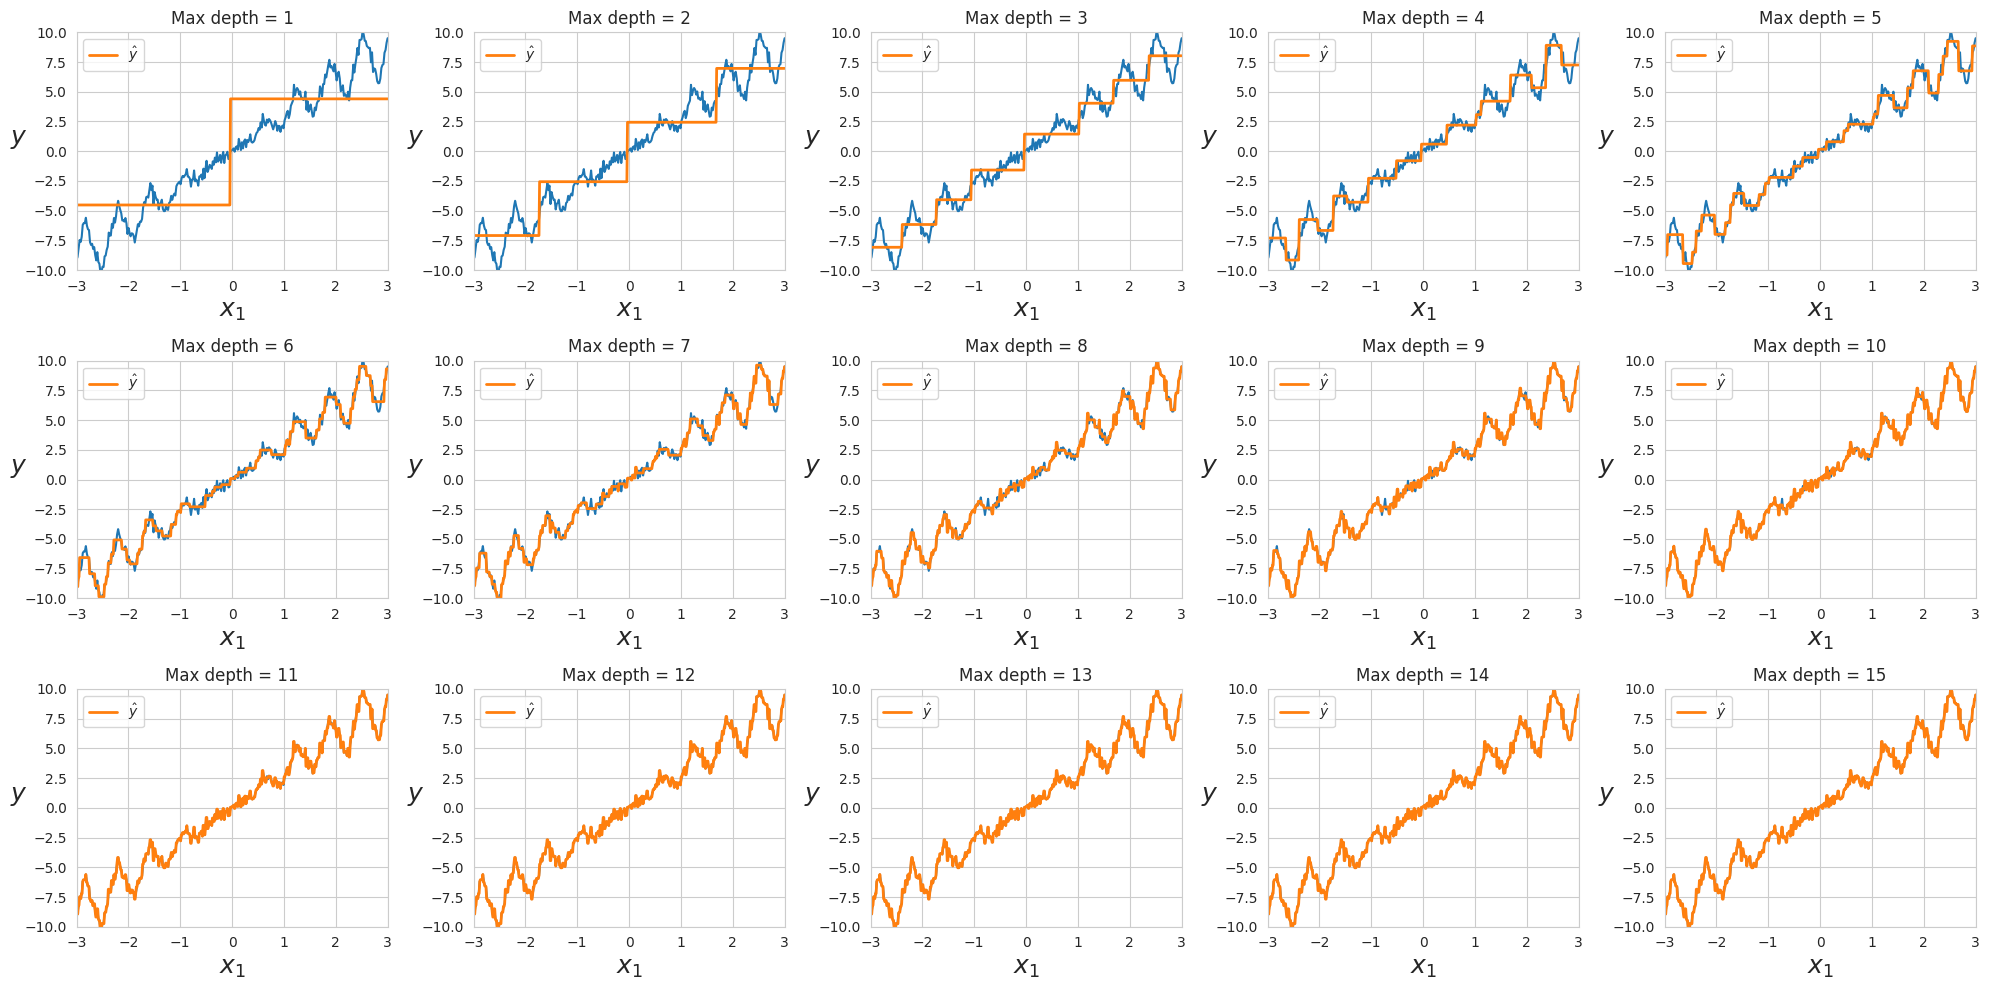

In [9]:
max_depth_values = range(1, 16)

plt.figure(figsize=(20, 10))
for i, max_depth in enumerate(max_depth_values):
    tree_reg = DecisionTreeRegressor(max_depth=max_depth, random_state=SEED)
    tree_reg.fit(X, y)

    plt.subplot(3, 5, i+1)
    plt.plot(X.reshape(-1), y.reshape(-1))
    plot_regression_predictions(tree_reg, X, y)
    plt.title(f"Max depth = {max_depth}")

plt.tight_layout()
plt.show()

### Задание 2. Random forest

Теперь давайте немного подготовимся к тому, чтобы реализовать свой собственный случайный лес, а потом реализуем его.

#### Задание 2. 1. Простое ансамблирование

**1 балла**

Представим, что у нас есть 101 классификатор. Каждый может с вероятностью `p` (равной для всех моделей) правильно предсказать класс объекта. Будем делать предсказания по большинству голосов (majority vote). Постройте зависимость вероятности правильно классифицировать объект от значения `p`. Вам может быть полезная следующая формула:

$$ \large \mu = \sum_ {i = 51} ^ {101} C_{101} ^ ip ^ i (1-p) ^ {101-i} $$

In [ ]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

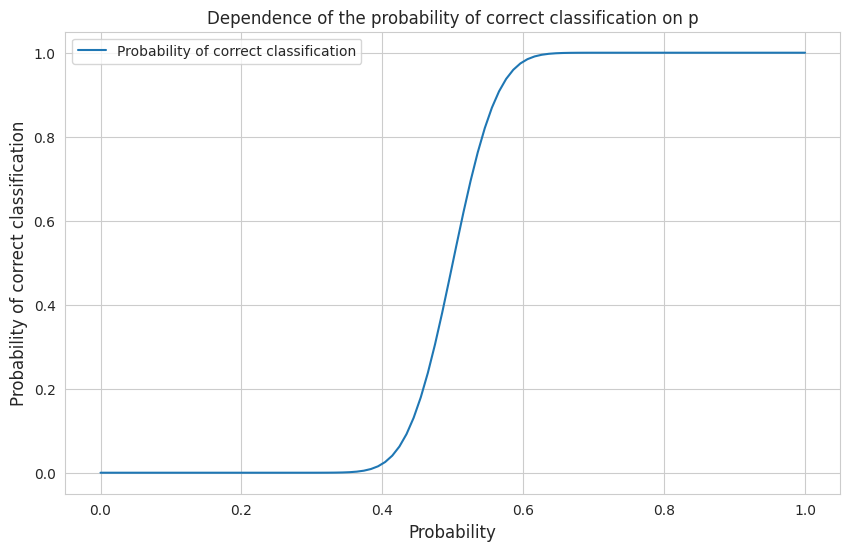

In [10]:
def prob_correct_classification(p):
    mu = sum(np.math.comb(101, i) * (p**i) * ((1-p)**(101-i)) for i in range(51, 102))
    return mu

p_values = np.linspace(0, 1, 100)
probabilities = [prob_correct_classification(p) for p in p_values]

plt.figure(figsize=(10, 6))
plt.plot(p_values, probabilities, label='Probability of correct classification')
plt.xlabel('Probability', fontsize=12)
plt.ylabel('Probability of correct classification', fontsize=12)
plt.title('Dependence of the probability of correct classification on p')
plt.legend()
plt.show()

А теперь давайте посмотрим на другую ситуацию. У нас есть фиксированная вероятность того, что модель правильно классифицирует объект `p = 0.65`. Постройте зависимость вероятности правильно классифицировать объект от числа моделей в ансамбле.

In [ ]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

In [ ]:
def prob_correct_classification(p, N):
    probabilities = [np.math.comb(N, k) * (p**k) * ((1-p)**(N-k)) for k in range(int(np.ceil(N/2)), N+1)]
    return sum(probabilities)

N_values = np.arange(1, 101)
probabilities = [prob_correct_classification(0.65, N) for N in N_values]

plt.figure(figsize=(10, 6))
plt.scatter(N_values, probabilities, marker='o')
plt.xlabel('Number of models in the ensemble', fontsize=12)
plt.ylabel('Probability of correct classification', fontsize=12)
plt.title('Dependence of the probability of correct classification on the number of models in the ensemble')
plt.show()

Опишите ваши наблюдения:

* в первом случае мы видим, что совершается резкий скачок вероятности правильно классифицировать объект в районе 0.5, так как в этом случае мы получаем, что больше половины классификаторов могут определить объект верно. А при значениях от 0.6 мы выходит на стопроцентную вероятность верно классифицировать объект.
* во втором случае что в зависимости от четного/нечетного количества классификаторов в ансамбле при малых значениях, у нас получается две кривые (одна соответствует четным количествам, вторая - нечетным), которы, при увеличении количества классификаторов сходятся к единице вероятности.

#### Задание 2. 2. Реализация простого RF

**4 балла**

Реализуйте свой собственный класс `RandomForestClassifierCustom`, используя в качестве базовой модели `DecisionTreeClassifier` из `sklearn`.

Небольшое описание:
- Используйте приведенный ниже код
- В методе `fit` в цикле (`i` от 0 до `n_estimators-1`):
    * Зафиксируйте генератор случайных чисел следующим образом np.random.seed(`random_state + i`). Идея в том, что на каждой итерации у нас будет новое значение для генератора случайных чисел, что добавит побольше "случайности", но в то же время мы сможем иметь воспроизводимые результаты
    * После чего выберите `max_features` признаков **без возвращения/without replacement**, сохраните список выбранных признаков (их индексов) в `self.feat_ids_by_tree`
    * Также создайте псевдовыборку при помощи бутстрэпа (выбор **с возвращением/with replacement**) из тренировочных данных. Может помочь функция `np.random.choice` и ее аргумент `replace`
    * Обучите дерево решений с параметрами, заданными в конструкторе класса `max_depth`, `max_features` и `random_state` на полученной псевдовыборке.
- Метод `fit` должен возвращать текущий экземпляр класса `RandomForestClassifierCustom`, то есть `self` (все по-взрослому, как в `sklearn`)
- В методе `predict_proba` мы должны пройти циклом по всем деревьям. Для каждого предсказания, нам нужно будет брать только те признаки, на которых училось изначальное дерево, поэтому мы и сохраняли эту информацию в артрибуте `self.feat_ids_by_tree`. Этот метод должен возвращать предсказанные вероятности (можно делать двумя способами: для каждого дерева предсказывать значение при помощи метода `predict_proba` и потом усреднять эти вероятности, или к примеру пользоваться методом `predict` и также считать среднее.

In [11]:
class RandomForestClassifierCustom(BaseEstimator):
    def __init__(
        self, n_estimators=10, max_depth=None, max_features=None, random_state=SEED
    ):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.random_state = random_state

        self.trees = []
        self.feat_ids_by_tree = []

    def fit(self, X, y):
        self.classes_ = sorted(np.unique(y))

        for i in range(self.n_estimators-1):
            # реализуем RSM на уровне узлов
            np.random.seed(self.random_state + i)
            feat_ids = np.random.choice(range(X.shape[1]), self.max_features, replace=False)
            self.feat_ids_by_tree.append(feat_ids)

            # реализуем Bagging
            sample_indices = np.random.choice(range(X.shape[0]), X.shape[0], replace=True)
            X_bootstrap = X[sample_indices][:, feat_ids]
            y_bootstrap = y[sample_indices]
            tree = DecisionTreeClassifier(max_depth=self.max_depth, \
                                           max_features=self.max_features, random_state=self.random_state)
            tree.fit(X_bootstrap, y_bootstrap)
            self.trees.append(tree)

        return self

    def predict_proba(self, X):
        probas = np.zeros((X.shape[0], 2))

        for feat_ids, tree in zip(self.feat_ids_by_tree, self.trees):
            X_subset = X[:, feat_ids]
            probas += tree.predict_proba(X_subset)

        return probas / len(self.trees)

    def predict(self, X):
        probas = self.predict_proba(X)
        predictions = np.argmax(probas, axis=1)

        return predictions

Протестируем нашу реализацию на искусственных данных. Визуализируйте разделяющую границу, которую рисует ваша модель при помощи функции `plot_decision_boundary` (см. примеры в лекции).

In [12]:
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(["#ffdab9","#9898ff", "#4B0082"])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(["#ffdab9", "#4c4c7f", "#4B0082"])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

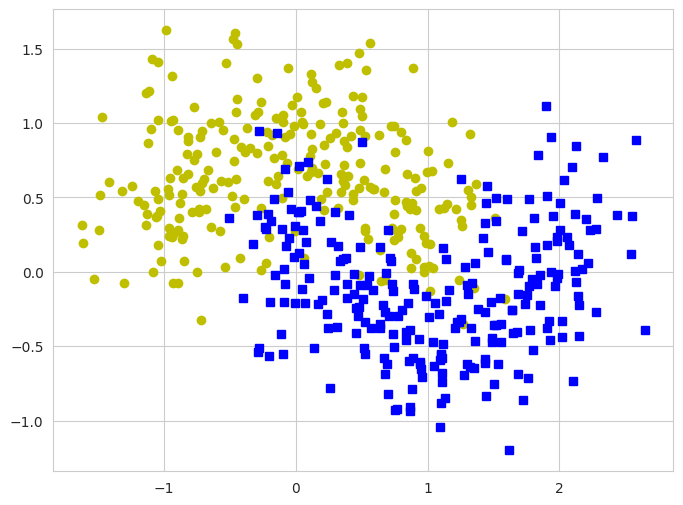

In [13]:
X, y = datasets.make_moons(n_samples=500, noise=0.30, random_state=SEED)

plt.figure(figsize=(8, 6))
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.show()

In [ ]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

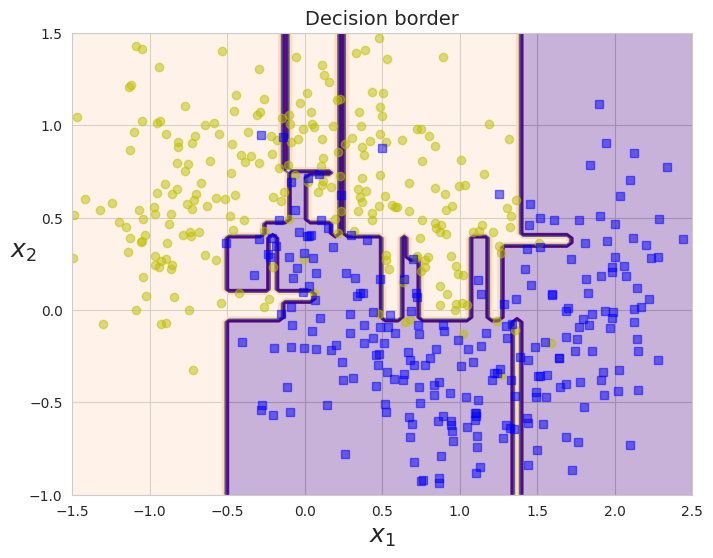

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)

plt.figure(figsize=(8, 6))
clf = DecisionTreeClassifier(max_depth=20, random_state=42)
clf.fit(X_train, y_train)
plot_decision_boundary(clf, X, y)
plt.title("Decision border", fontsize=14)
plt.show()

Подберите наилучшие гиперпараметры, при которых разделяющая граница будет, на ваш взгляд, оптимальной с точки зрения bias-variance. Можно также подключить какие-то метрики для выбора лучшей модели.

In [ ]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

In [15]:
param_grid = {
    'max_depth': [i for i in range(1, 16)],
    'min_samples_split':[i for i in range(1, 50)],
    'criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print(f'Оптимальные гиперпараметры: {grid_search.best_params_}\nAccuracy score = {round(grid_search.best_score_, 4)}')

Оптимальные гиперпараметры: {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 34}
Accuracy score = 0.912


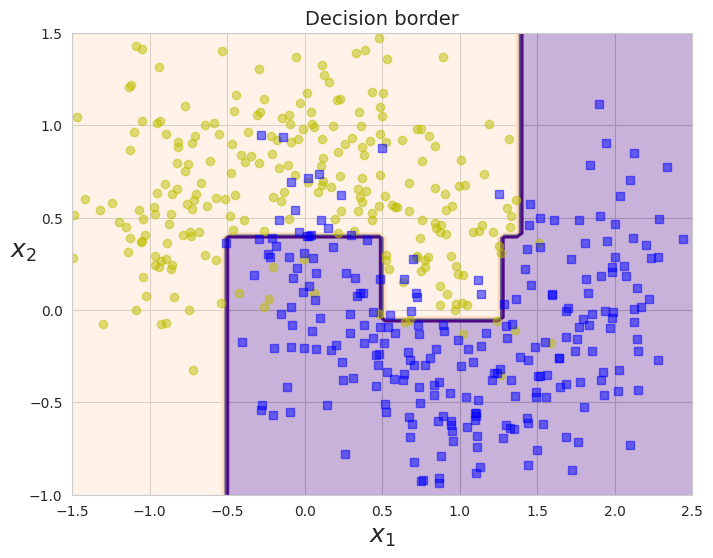

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)

plt.figure(figsize=(8, 6))
clf = DecisionTreeClassifier(max_depth=5, random_state=42, criterion='gini', min_samples_split=34)
clf.fit(X_train, y_train)
plot_decision_boundary(clf, X, y)
plt.title("Decision border", fontsize=14)
plt.show()

#### Задание 2. 3. Корреляция базовых моделей

**3 балла**

Как мы выянили на лекции, для того, чтобы bagging работал хорошо, предсказания наших моделей не должны сильно коррелировать. Для этого в случайном лесе применяются различные подходы, в том числе и RSM. Давайте посмотрим, как влияет параметр `max_features` на корреляцию базовых моделей в случайном лесу из `sklearn`. В качестве примера будем использовать датасет `breast_cancer`. Для расчета корреляций используйте приведенную ниже функцию `base_model_pair_correlation`. Для каждой модели у вас будет получаться набор значений (попарные корреляции всех деревьев), дальше можно изобразить их в виде боксплотов, как мы на лекции рисовали распределение метрик.

In [16]:
# Функция для расчета попарных корреляций базовых моделей в случайном лесу
def base_model_pair_correlation(ensemble, X):
    corrs = []
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        ypred_t2 = est2.predict_proba(Xj_test)[:, 1]

        corrs.append(pearsonr(ypred_t1, ypred_t2)[0])
    return np.array(corrs)

In [17]:
# Загрузим данные
breast_cancer = datasets.load_breast_cancer()
X = breast_cancer.data
y = breast_cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

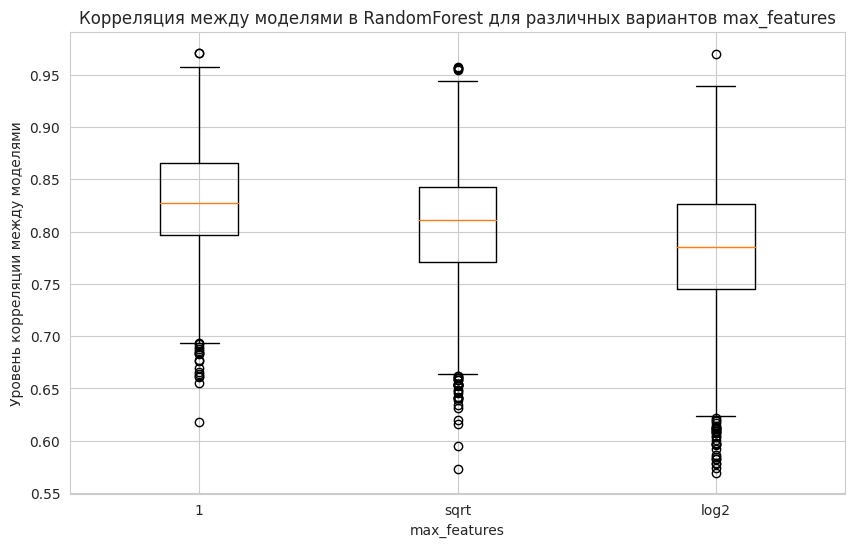

In [18]:
max_features_options = [None, 'sqrt', 'log2']
correlation_results = []

for max_features_val in max_features_options:
    rf = RandomForestClassifier(n_estimators=100, max_features=max_features_val, random_state=42)
    rf.fit(X_train, y_train)

    correlations = base_model_pair_correlation(rf, X_test)
    correlation_results.append(correlations)

# Изобразим корреляции в виде боксплотов
plt.figure(figsize=(10, 6))
plt.boxplot(correlation_results, labels=max_features_options)
plt.xlabel('max_features')
plt.ylabel('Level of correlation between models')
plt.title('Correlation between models in RandomForest for different variants of max_features')
plt.show()

Теперь давайте посмотрим, как на это влияет параметр `max_depth`:

In [ ]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

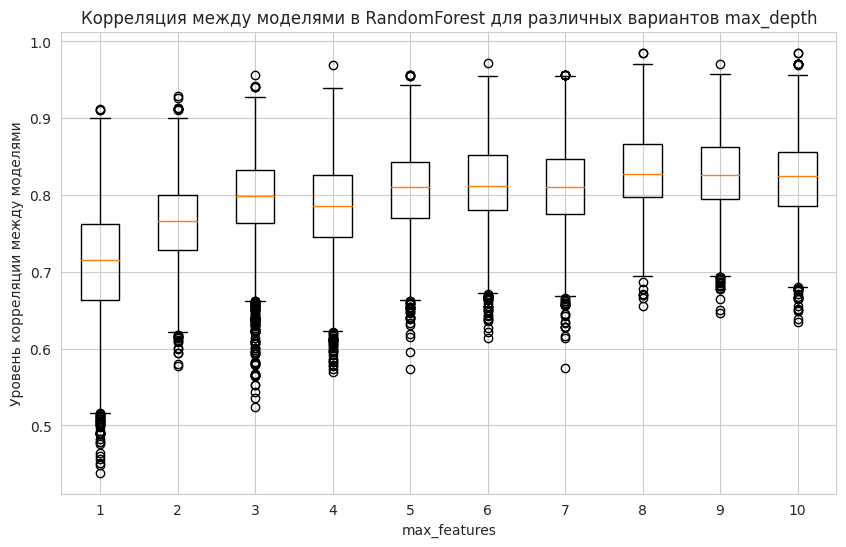

In [36]:
max_depth = [i for i in range(1, 11)]
correlation_results = []

for max_depth_val in max_depth:
    rf = RandomForestClassifier(n_estimators=100, max_features=max_depth_val, random_state=42)
    rf.fit(X_train, y_train)

    correlations = base_model_pair_correlation(rf, X_test)
    correlation_results.append(correlations)

# Изобразим корреляции в виде боксплотов
plt.figure(figsize=(10, 6))
plt.boxplot(correlation_results, labels=max_depth)
plt.xlabel('max_features')
plt.ylabel('Уровень корреляции между моделями')
plt.title('Корреляция между моделями в RandomForest для различных вариантов max_depth')
plt.grid(True)
plt.show()

Опишите ваши наблюдения:

* в случае гиперпараметра max_features наблюдаем корреляцию между *sqrt* и *log2*
* в случае гиперпараметра max_depth боксплоты практически для всех значений сильно коррелируют

### Задание 3. Строим большой ансамбль

**4 балла + 3 дополнительных за скор выше 0.87**

В данной задаче вам нужно диагностировать сердечное заболевание у людей по медицинским показателям.

In [20]:
heart_dataset = pd.read_csv("data/heart.csv")

In [22]:
X = heart_dataset.drop("target", axis=1)
y = heart_dataset["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)
X_train.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
178,43,1,0,120,177,0,0,120,1,2.5,1,0,3
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3
201,60,1,0,125,258,0,0,141,1,2.8,1,1,3
246,56,0,0,134,409,0,0,150,1,1.9,1,2,3
153,66,0,2,146,278,0,0,152,0,0.0,1,1,2


Обучите разнообразные классификаторы, приведенные ниже, а также ансамбль `VotingClassifier` из `sklearn.ensemble`, объединяющий эти классификаторы с помощью жесткого или мякого голосования (параметр `voting =` `'hard'` или `'soft'` соответственно). Оцените качество моделей с помощью кросс-валидации на тренировочном наборе, используя функцию `cross_val_score` и метрику `f1`. Часть моделей отсюда мы не проходили, о них можно почитать дополнительно, но в принципе для задания не очень важно знать принципы их работы (но, если есть время, то почитайте, там интересно).

In [24]:
dt = DecisionTreeClassifier(random_state=SEED, max_depth=10, min_samples_leaf=10)
rf = RandomForestClassifier(n_estimators=50, random_state=SEED)
etc = ExtraTreesClassifier(random_state=SEED)
knn = KNeighborsClassifier(n_neighbors=5, weights="distance")
svc_lin = SVC(kernel='linear', probability=True, random_state=SEED)
svc_rbf = SVC(kernel='rbf', probability=True, random_state=SEED)
cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
lgbm = lightgbm.LGBMClassifier(random_state=SEED)
lgbm_rf = lightgbm.LGBMClassifier(boosting_type="rf", bagging_freq=1, bagging_fraction=0.7, random_state=SEED)
xgb = xgboost.XGBClassifier(random_state=SEED)
xgb_rf = xgboost.XGBRFClassifier(random_state=SEED)
lr = LogisticRegression(solver='liblinear', max_iter=10000)
nb = GaussianNB()

base_models = [("DT", dt), ("RF", rf),
               ("ETC", etc), ("KNN", knn),
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf),
               ("CAT", cat), ("LGBM", lgbm),
               ("LGBM_RF", lgbm_rf), ("XGB", xgb),
               ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]

Здесь могут возникать различные предупреждения при обучении бустингов, не волнуйтесь, все нормально, просто они обычно очень разговорчивые)

In [ ]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##
voting_hard = VotingClassifier(estimators=base_models, voting='hard')
voting_soft = VotingClassifier(estimators=base_models, voting='soft')
## END YOUR CODE HERE ##

for model in [dt, rf, cat, etc, knn, svc_lin, svc_rbf, xgb, lgbm, xgb_rf, lgbm_rf, lr, nb, voting_hard, voting_soft]:
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1")
    print(f"{model.__class__.__name__}: {scores.mean()}")

Вы можете заметить, что ансамбль показывает хорошее, но не лучшее качество предсказания, попробуем его улучшить. Как вы знаете, ансамбли работают лучше, когда модели, входящие в них не скоррелированы друг с другом. Определите корреляцию предсказаний базовых моделей в ансамбле на тестовом наборе данных, и удалите из ансамбля те модели, чьи предсказания будут сильнее коррелировать с остальными. Воспользуйтесь функцией `base_model_pair_correlation_for_voting_clf`. **Спойлер**: далеко не факт, что если вы удалите две модели с корреляцией 0.95, то все станет сильно лучше, здесь все будет немного сложнее. Чтобы добиться максимального качества может понадобиться долгий перебор различных комбинаций моделей. Наилучший скор, который мне удалось достичь, это 0.915, но он получен весьма странной комбинацией алгоритмов, а еще и простым перебором всех вариантов)

In [30]:
def base_model_pair_correlation_for_voting_clf(ensemble, X):
    corrs = []
    base_model_names = [f"{est.__class__.__name__}" for est in ensemble.estimators_]
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        if not isinstance(est1, SVC):
            ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t1 = est1.decision_function(Xi_test)


        if not isinstance(est2, SVC):
            ypred_t2 = est2.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t2 = est2.decision_function(Xi_test)
        corrs.append((est1, est2, pearsonr(ypred_t1, ypred_t2)[0]))


    return corrs

In [234]:
base_models = [("DT", dt), ("SVC_LIN", svc_lin),
               ("CAT", cat), ("XGB_RF", xgb_rf), ("NB", nb)]

voting_hard = VotingClassifier(estimators=base_models, voting='hard')
voting_soft = VotingClassifier(estimators=base_models, voting='soft')

In [163]:
## ENTER YOUR CODE HERE (/¯◡ ‿ ◡)/¯☆*##

In [235]:
voting_soft.fit(X_train, y_train)
base_model_pair_correlation_for_voting_clf(voting_soft, X_test)

[(DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111),
  SVC(kernel='linear', probability=True, random_state=111),
  0.715376472596946),
 (DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111),
  0.7875690140798687),
 (DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=111),
  XGBRFClassifier(base_score=None, booster=None, callbacks=None,
                  colsample_bylevel=None, colsample_bytree=None, device=None,
                  early_stopping_rounds=None, enable_categorical=False,
                  eval_metric=None, feature_types=None, gamma=None,
                  grow_policy=None, importance_type=None,
                  interaction_constraints=None, max_bin=None,
                  max_cat_threshold=None, max_cat_to_onehot=None,
                  max_delta_step=None, max_depth=None, max_leaves=None,
                  min_child_weight=None, missing=nan, monotone_constraints=None,
                  multi_strategy=Non

In [236]:
score = cross_val_score(voting_soft, X_train, y_train, cv=3, scoring="f1")
print(f"voting_soft: {score.mean()}")

voting_soft: 0.8668502028935633


Мне удалось улучшить скор только до 0.8668.

### Задание 4. Определение оттока клиентов из телекома

**6 баллов + 7 дополнительных за высокое качество модели и различные эксперименты**

Будем предсказывать, уйдет ли от нас клиент (переменная `Churn?`). Данные можно скачать [здесь](https://www.kaggle.com/venky12347/churn-telecom). Это будет уже совсем взрослое задание, так как правильного ответа на него нет. Вам нужно будет разобраться с данными, правильно подготовить их для моделей, а также выбрать лучшую модель.

Задача минимум:

Выберите 2 модели &mdash; один случайный лес и один бустинг из приведенных ниже:

1. `xgboost.XGBClassifier`
2. `xgboost.XGBRFClassifier` &mdash; случайный лес от xgboost
3. `lightgbm.LGBMClassifier`
4. `lightgbm.LGBMClassifier(boosting_type="rf")` &mdash; случайный лес от lightgbm
5. `catboost.CatBoostClassifier`

И попробуйте разобраться с тем, как для этих моделей правильно настраивать гиперпараметры. Советую гуглить примерно следующее `how to choose best hyperparameters for lightgbm`. Там вы найдете кучу сложного и непонятного кода, но если с ним разобраться и научиться обучать нестандартные бустинги, то в плане табличных данных равных вам не будет)

In [116]:
data = pd.read_csv("data/churn.csv")
data

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,...,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,AZ,192,415,414-4276,no,yes,36,156.2,77,26.55,...,126,18.32,279.1,83,12.56,9.9,6,2.67,2,False.
3329,WV,68,415,370-3271,no,no,0,231.1,57,39.29,...,55,13.04,191.3,123,8.61,9.6,4,2.59,3,False.
3330,RI,28,510,328-8230,no,no,0,180.8,109,30.74,...,58,24.55,191.9,91,8.64,14.1,6,3.81,2,False.
3331,CT,184,510,364-6381,yes,no,0,213.8,105,36.35,...,84,13.57,139.2,137,6.26,5.0,10,1.35,2,False.


In [117]:
data = data.drop(['State', 'Phone'], axis=1)
data[["Int'l Plan", "VMail Plan"]] = data[["Int'l Plan", "VMail Plan"]].replace({'yes': True, 'no': False})
data[['Churn?']] = data[['Churn?']].replace({'True.': True, 'False.': False})

In [118]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Account Length  3333 non-null   int64  
 1   Area Code       3333 non-null   int64  
 2   Int'l Plan      3333 non-null   bool   
 3   VMail Plan      3333 non-null   bool   
 4   VMail Message   3333 non-null   int64  
 5   Day Mins        3333 non-null   float64
 6   Day Calls       3333 non-null   int64  
 7   Day Charge      3333 non-null   float64
 8   Eve Mins        3333 non-null   float64
 9   Eve Calls       3333 non-null   int64  
 10  Eve Charge      3333 non-null   float64
 11  Night Mins      3333 non-null   float64
 12  Night Calls     3333 non-null   int64  
 13  Night Charge    3333 non-null   float64
 14  Intl Mins       3333 non-null   float64
 15  Intl Calls      3333 non-null   int64  
 16  Intl Charge     3333 non-null   float64
 17  CustServ Calls  3333 non-null   i

In [119]:
data.describe()

,Account Length,Area Code,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,437.182418,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856
std,39.822106,42.371290,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491
min,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,408.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000
50%,101.000000,415.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000
75%,127.000000,510.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000
max,243.000000,510.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


In [120]:
data.nunique()

Account Length     212
Area Code            3
Int'l Plan           2
VMail Plan           2
VMail Message       46
Day Mins          1667
Day Calls          119
Day Charge        1667
Eve Mins          1611
Eve Calls          123
Eve Charge        1440
Night Mins        1591
Night Calls        120
Night Charge       933
Intl Mins          162
Intl Calls          21
Intl Charge        162
CustServ Calls      10
Churn?               2
dtype: int64

In [121]:
cat_features = []
for column in data.columns:
    if len(data[column].unique()) <= 46:
        cat_features.append(column)
cat_features

['Area Code',
 "Int'l Plan",
 'VMail Plan',
 'VMail Message',
 'Intl Calls',
 'CustServ Calls',
 'Churn?']

In [122]:
num_features = data.drop(cat_features, axis=1).columns
num_features

Index(['Account Length', 'Day Mins', 'Day Calls', 'Day Charge', 'Eve Mins',
       'Eve Calls', 'Eve Charge', 'Night Mins', 'Night Calls', 'Night Charge',
       'Intl Mins', 'Intl Charge'],
      dtype='object')

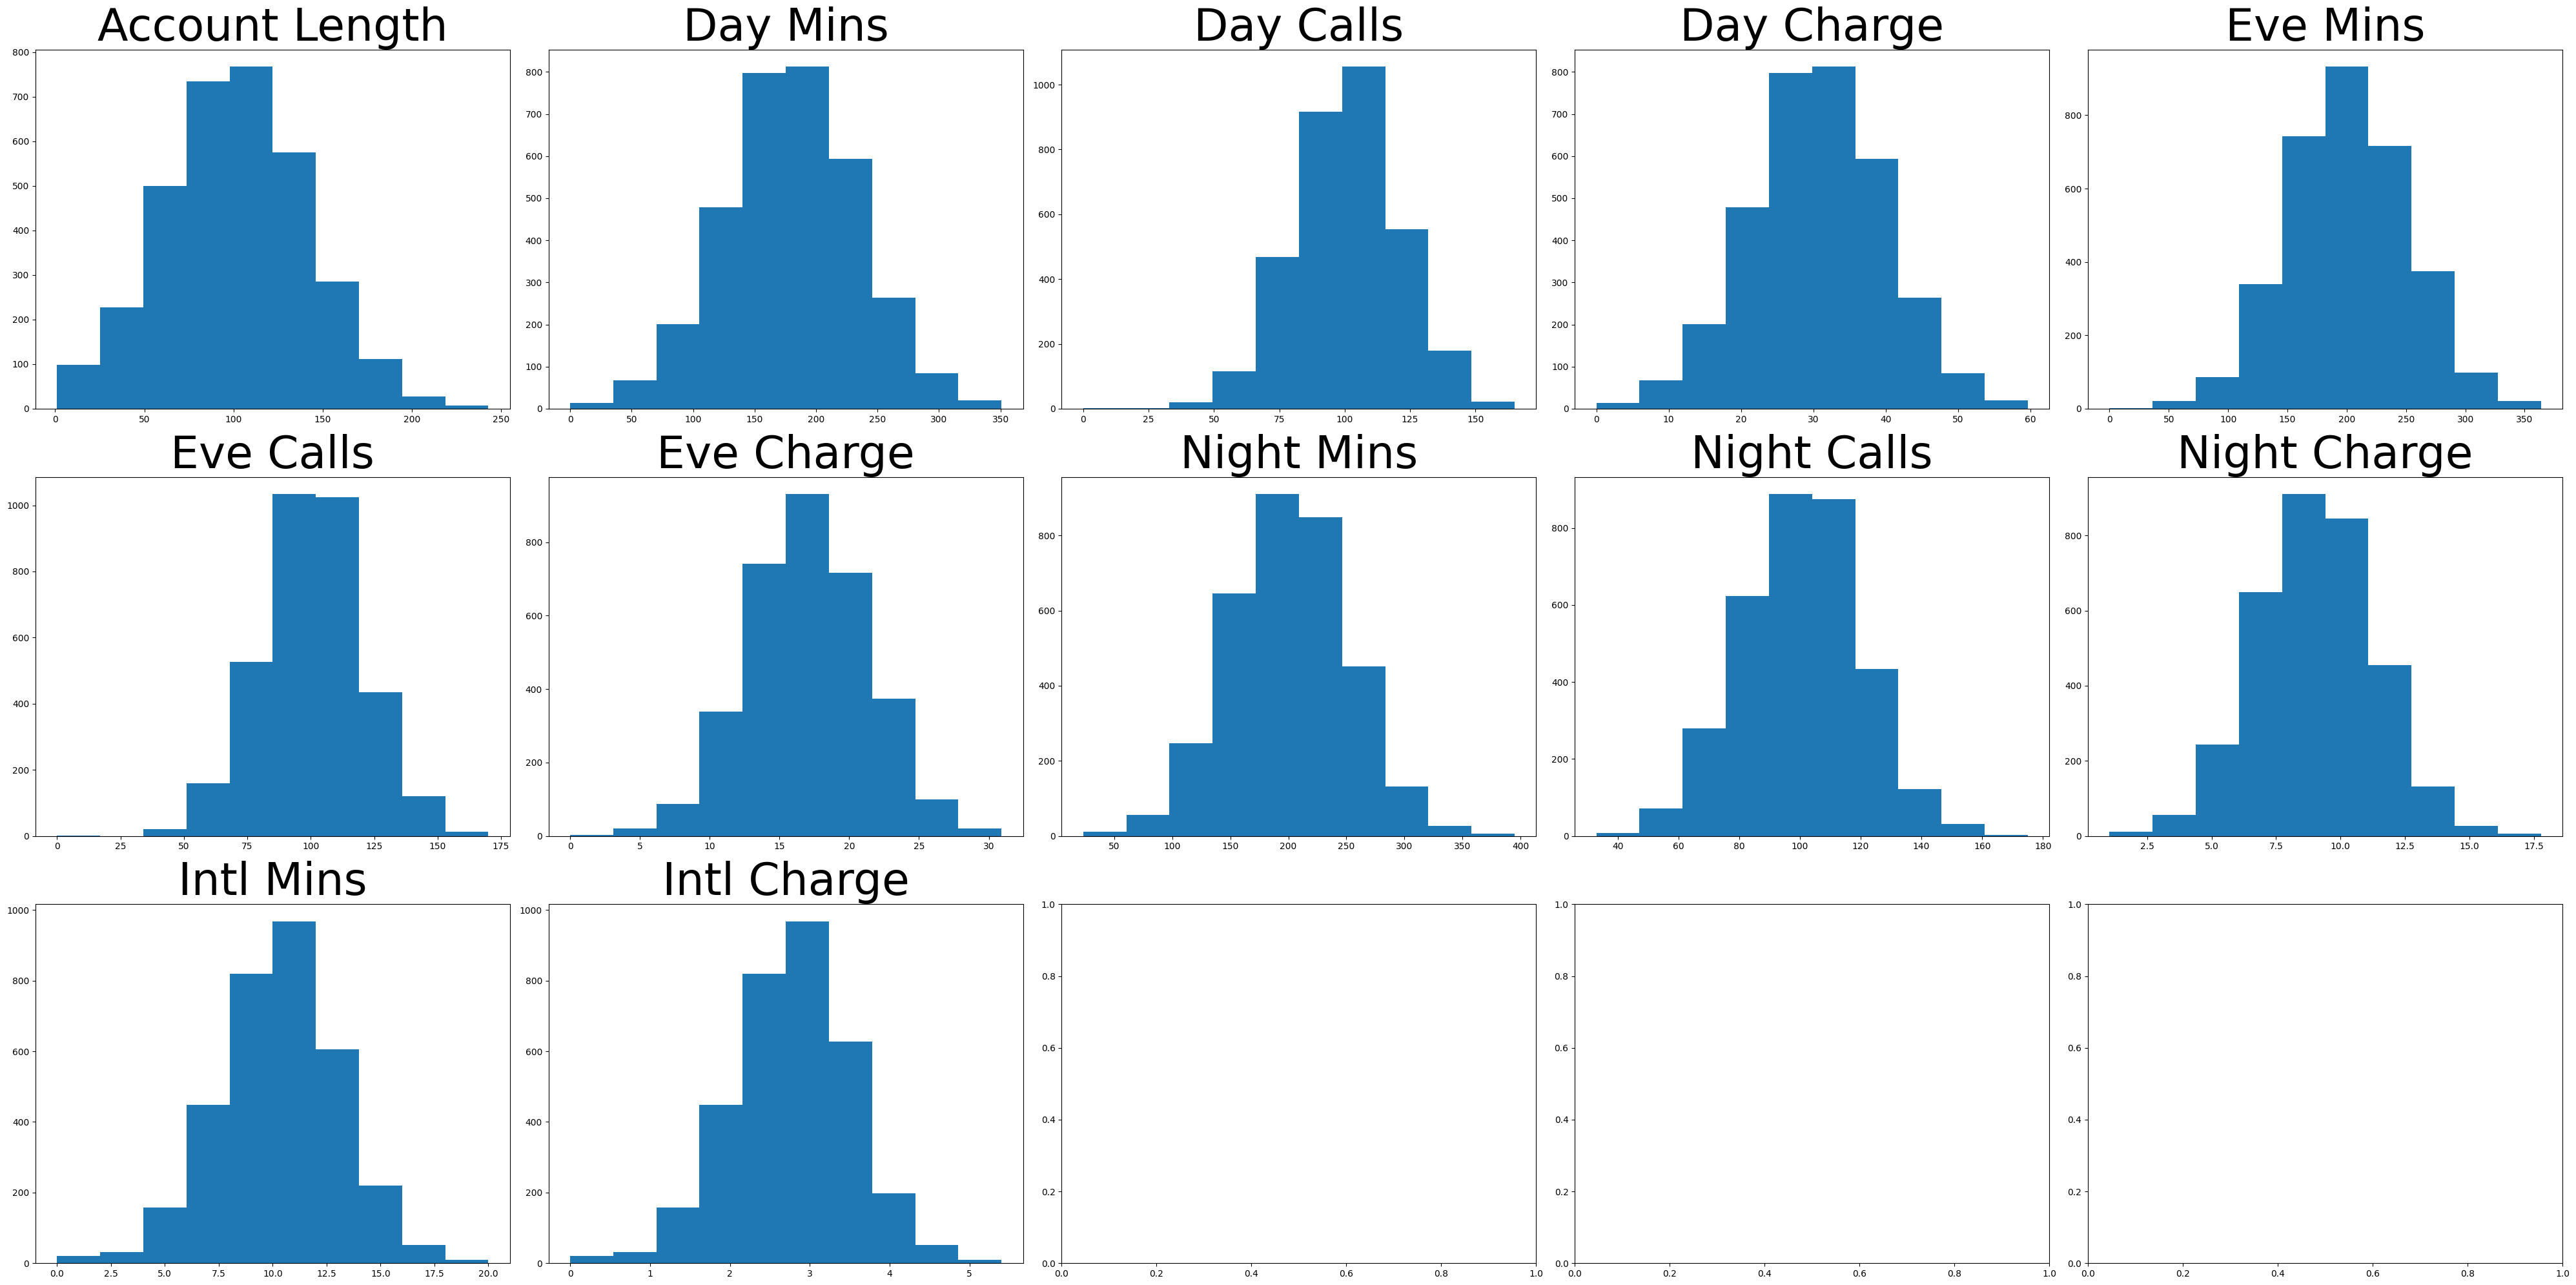

In [11]:
def draw_histplot(df, columns, nrows, ncols, n):

    fig, axes = plt.subplots(nrows, ncols, figsize=(40, 20))

    # Создаем график для каждой колонки
    for i, column in enumerate(columns):
        row = i // n
        col = i % n
        axes[row, col].hist(df[column])
        axes[row, col].set_title(column, size=50)

    # Отображаем графики
    plt.tight_layout()
    plt.show()

draw_histplot(data, num_features, 3, 5, 5)

Распредления числовых переменных схожи с нормальным и выбросов не видно.

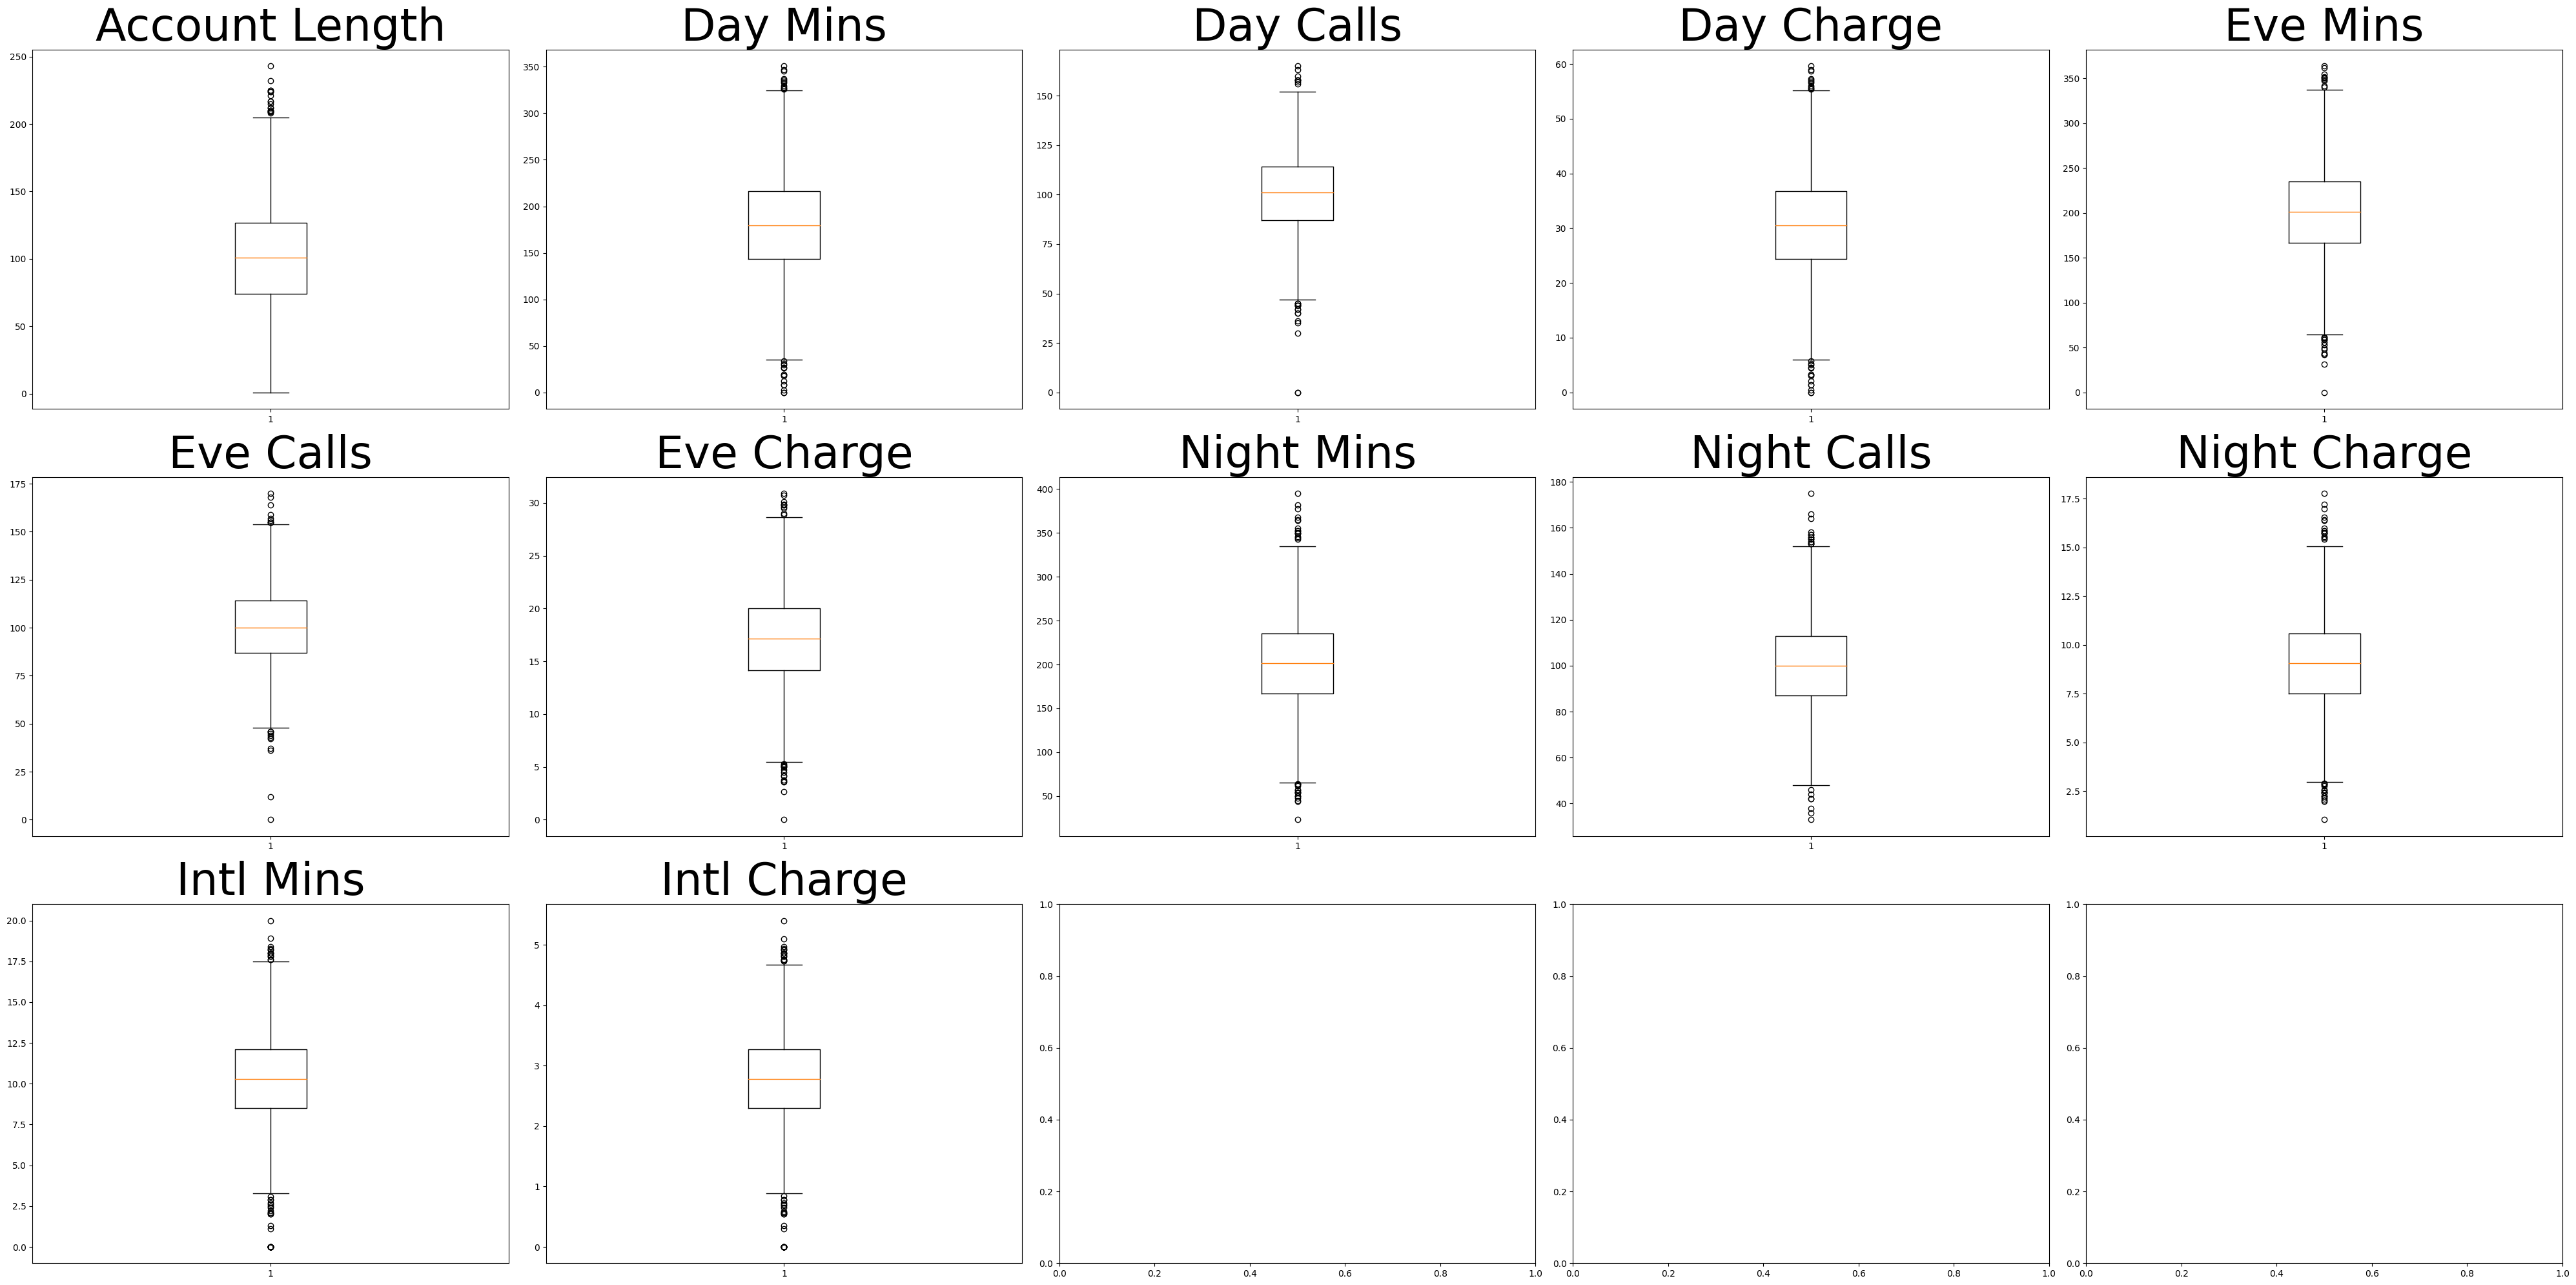

In [12]:
def draw_boxplot(df, columns, nrows, ncols, n):

    fig, axes = plt.subplots(nrows, ncols, figsize=(40, 20))

    # Создаем график для каждой колонки
    for i, column in enumerate(columns):
        row = i // n
        col = i % n
        axes[row, col].boxplot(df[column])
        axes[row, col].set_title(column, size=50)

    # Отображаем графики
    plt.tight_layout()
    plt.show()

draw_boxplot(data, num_features, 3, 5, 5)

In [13]:
data[num_features].corr()

,Account Length,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Charge
Account Length,1.000000,0.006216,0.038470,0.006214,-0.006757,0.019260,-0.006745,-0.008955,-0.013176,-0.008960,0.009514,0.009546
Day Mins,0.006216,1.000000,0.006750,1.000000,0.007043,0.015769,0.007029,0.004323,0.022972,0.004300,-0.010155,-0.010092
Day Calls,0.038470,0.006750,1.000000,0.006753,-0.021451,0.006462,-0.021449,0.022938,-0.019557,0.022927,0.021565,0.021666
Day Charge,0.006214,1.000000,0.006753,1.000000,0.007050,0.015769,0.007036,0.004324,0.022972,0.004301,-0.010157,-0.010094
Eve Mins,-0.006757,0.007043,-0.021451,0.007050,1.000000,-0.011430,1.000000,-0.012584,0.007586,-0.012593,-0.011035,-0.011067
Eve Calls,0.019260,0.015769,0.006462,0.015769,-0.011430,1.000000,-0.011423,-0.002093,0.007710,-0.002056,0.008703,0.008674
Eve Charge,-0.006745,0.007029,-0.021449,0.007036,1.000000,-0.011423,1.000000,-0.012592,0.007596,-0.012601,-0.011043,-0.011074
Night Mins,-0.008955,0.004323,0.022938,0.004324,-0.012584,-0.002093,-0.012592,1.000000,0.011204,0.999999,-0.015207,-0.015180
Night Calls,-0.013176,0.022972,-0.019557,0.022972,0.007586,0.007710,0.007596,0.011204,1.000000,0.011188,-0.013605,-0.013630
Night Charge,-0.008960,0.004300,0.022927,0.004301,-0.012593,-0.002056,-0.012601,0.999999,0.011188,1.000000,-0.015214,-0.015186


Есть переменные, которые сильно друг с другом коррелируют. Поэтому исключим по одной из пары.

In [123]:
num_features = data.drop(cat_features + ['Intl Charge', 'Night Charge'], axis=1).columns
data[num_features].corr()

,Account Length,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Intl Mins
Account Length,1.000000,0.006216,0.038470,0.006214,-0.006757,0.019260,-0.006745,-0.008955,-0.013176,0.009514
Day Mins,0.006216,1.000000,0.006750,1.000000,0.007043,0.015769,0.007029,0.004323,0.022972,-0.010155
Day Calls,0.038470,0.006750,1.000000,0.006753,-0.021451,0.006462,-0.021449,0.022938,-0.019557,0.021565
Day Charge,0.006214,1.000000,0.006753,1.000000,0.007050,0.015769,0.007036,0.004324,0.022972,-0.010157
Eve Mins,-0.006757,0.007043,-0.021451,0.007050,1.000000,-0.011430,1.000000,-0.012584,0.007586,-0.011035
Eve Calls,0.019260,0.015769,0.006462,0.015769,-0.011430,1.000000,-0.011423,-0.002093,0.007710,0.008703
Eve Charge,-0.006745,0.007029,-0.021449,0.007036,1.000000,-0.011423,1.000000,-0.012592,0.007596,-0.011043
Night Mins,-0.008955,0.004323,0.022938,0.004324,-0.012584,-0.002093,-0.012592,1.000000,0.011204,-0.015207
Night Calls,-0.013176,0.022972,-0.019557,0.022972,0.007586,0.007710,0.007596,0.011204,1.000000,-0.013605
Intl Mins,0.009514,-0.010155,0.021565,-0.010157,-0.011035,0.008703,-0.011043,-0.015207,-0.013605,1.000000


Предобработаем наши данные

In [126]:
X, y = data.drop(['Churn?', 'Intl Charge', 'Night Charge'], axis=1), data['Churn?']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED, test_size = 0.2)

In [134]:
from xgboost import XGBRFClassifier
from sklearn.metrics import accuracy_score

model = XGBRFClassifier(n_estimators=100, max_depth=3, subsample=0.8, colsample_bynode=0.8, random_state=SEED)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.9010494752623688


In [137]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(iterations=100, depth=3, learning_rate=0.1, loss_function='Logloss', random_seed=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

0:	learn: 0.6369151	total: 3.82ms	remaining: 379ms
1:	learn: 0.5933598	total: 6.11ms	remaining: 299ms
2:	learn: 0.5553786	total: 8.96ms	remaining: 290ms
3:	learn: 0.5192969	total: 11.6ms	remaining: 279ms
4:	learn: 0.4876898	total: 13.6ms	remaining: 259ms
5:	learn: 0.4616505	total: 16.6ms	remaining: 260ms
6:	learn: 0.4390303	total: 19.1ms	remaining: 253ms
7:	learn: 0.4229871	total: 21.6ms	remaining: 248ms
8:	learn: 0.4085889	total: 24.1ms	remaining: 243ms
9:	learn: 0.3916714	total: 27.4ms	remaining: 247ms
10:	learn: 0.3760085	total: 29.4ms	remaining: 238ms
11:	learn: 0.3628909	total: 34.3ms	remaining: 252ms
12:	learn: 0.3522824	total: 37.1ms	remaining: 249ms
13:	learn: 0.3421783	total: 40.3ms	remaining: 248ms
14:	learn: 0.3323101	total: 43.2ms	remaining: 245ms
15:	learn: 0.3232050	total: 44.6ms	remaining: 234ms
16:	learn: 0.3153843	total: 46.5ms	remaining: 227ms
17:	learn: 0.3080856	total: 49.6ms	remaining: 226ms
18:	learn: 0.3011025	total: 52.2ms	remaining: 222ms
19:	learn: 0.2959376	t

Второй вариант выдает метрику лучше.

### Задание 5. Рисуем

**дополнительно 0.5 балла**

Наверняка, в процессе выполнения этого задания вас переполняли какие-то эмоции. Нарисуйте что-то, что бы могло бы передать их (я сам не умею, так что, если это будет просто квадрат, тоже подойдет). Прикрепите сюда свой рисунок:

In [ ]:
## PASTE YOUR MASTERPIECE HERE (/¯◡ ‿ ◡)/¯☆*##

![я решаю 3 задание](data/1.jpeg)

### Therapy time

Очень интересное дз, мне крайне понравилось. Местами я не смог уделить достаточно внимания, чтобы полностью погрузиться в тему, к примеру, в разделе с подбором моделей для ансамбля, я не изучил что каждая из себя представляет. НО я собираюсь это ликвидировать!
